# 2D histogram of the optical depth $\tau$

Below I calculate the 2-d and averaged 1-d spectra for the optical depth, which gives the penetration
depth of photons through a cloud, and is closely related to cloud thickness

In [38]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [39]:
from matplotlib import pyplot as plt
import urllib
import os
filelist=['a17.nc']
data_download=True
if data_download:
    for the_file in filelist:
        url='http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}'.format(the_file)
        urllib.request.urlretrieve(url,the_file)
print("download {}: size is {:6.2g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))

download a17.nc: size is     17 Mbytes


In [40]:
from netCDF4 import Dataset
with Dataset(filelist[0]) as nc:
    tau=nc.variables['tau'][...]

## Character of the optical depth field

The image below shows one of the marine boundary layer landsat scenes analyzed in 
[Lewis et al., 2004](http://onlinelibrary.wiley.com/doi/10.1029/2003JD003742/full)

It is a 2048 x 2048 pixel image taken by Landsat 7, with the visible reflectivity converted to
cloud optical depth.   The pixels are 25 m x 25 m, so the scene extends for about 50 km x 50 km

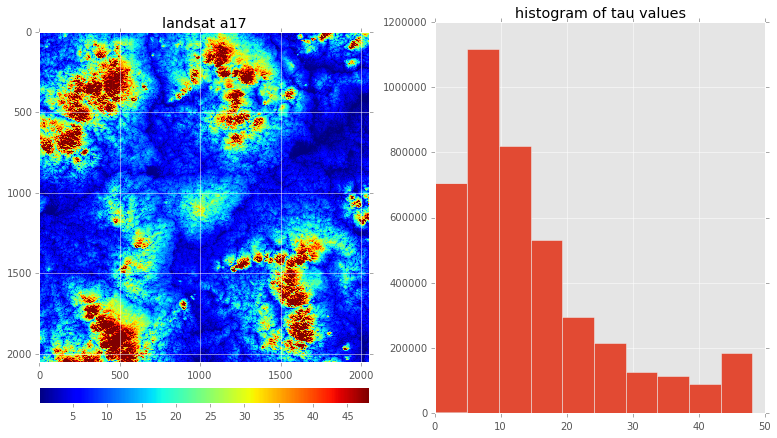

In [41]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.close('all')
fig,ax=plt.subplots(1,2,figsize=(13,7))
ax[0].set_title('landsat a17')
im0=ax[0].imshow(tau)
im1=ax[1].hist(tau.ravel())
ax[1].set_title('histogram of tau values')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im0,orientation='horizontal',cax=cax)

## ubc_fft class

In the next cell I define a class that calculates the 2-d fft for a square image

in the method ```power_spectrum``` we calculate both the 2d fft and the power spectrum
and save them as class attributes.  In the method ```annular_average``` I take the power spectrum,
which is the two-dimensional field  $E(k_x, k_y)$ (in cartesian coordinates) or $E(k,\theta)$ (in polar coordinates).
In the method ```annular_avg``` I take the average

$$
\overline{E}(k) = \int_0^{2\pi} E(k, \theta) d\theta
$$

and plot that average with the method ```graph_spectrum```

In [42]:
from netCDF4 import Dataset
import numpy as np
import math
from numpy import fft
from matplotlib import pyplot as plt


class ubc_fft:

    def __init__(self, filename, var, scale):
        """
           Input filename, var=variable name, 
           scale= the size of the pixel in km

           Constructer opens the netcdf file, reads the data and
           saves the twodimensional fft
        """
        with Dataset(filename,'r') as fin:
            data = fin.variables[var][...]
        data = data - data.mean()
        if data.shape[0] != data.shape[1]:
            raise ValueError('expecting square matrix')
        self.xdim = data.shape[0]     # size of each row of the array
        self.midpoint = int(math.floor(self.xdim/2))
        root,suffix = filename.split('.')
        self.filename = root
        self.var = var
        self.scale = float(scale)
        self.data = data
        self.fft_data = fft.fft2(self.data)
    
    def power_spectrum(self):
        """
           calculate the power spectrum for the 2-dimensional field
        """
        #
        # fft_shift moves the zero frequency point to the  middle
        # of the array  
        #
        fft_shift = fft.fftshift(self.fft_data)
        spectral_dens = fft_shift*np.conjugate(fft_shift)/(self.xdim*self.xdim)
        spectral_dens = spectral_dens.real
        #
        # dimensional wavenumbers for 2dim spectrum  (need only the kx
        # dimensional since image is square
        #
        k_vals = np.arange(0,(self.midpoint))+1
        k_vals = (k_vals-self.midpoint)/(self.xdim*self.scale)
        self.spectral_dens=spectral_dens
        self.k_vals=k_vals
    
    def square_avg(self,avg_binwidth):
        numbins = int(round((math.sqrt(2)*self.xdim/avg_binwidth),0)+1)
        avg_spec_sq = np.zeros(numbins,np.float64)
        bin_count_sq = np.zeros(numbins,np.float64)
        cpt = self.xdim/2
        
        for i in range(self.xdim):
            iD = abs(cpt-i)
            for j in range(self.xdim):
                jD = abs(cpt-j)
                if iD > jD:
                    jD = iD
                bin_num=int(math.floor(jD/avg_binwidth))
                avg_spec_sq[bin_num]=avg_spec_sq[bin_num]+jD*self.spectral_dens[i,j]
                bin_count_sq[bin_num]+=1
        for i in range(numbins):
            if bin_count_sq[i]>0:
                avg_spec_sq[i]=avg_spec_sq[i]*avg_binwidth/bin_count_sq[i]/(25)
        self.avg_spec_sq=avg_spec_sq
        
        self.kbins=np.arange(numbins)+1
        self.kbins=self.kbins[0:self.midpoint]
        self.avg_spec_sq=self.avg_spec_sq[0:self.midpoint]
    
    def annular_avg(self,avg_binwidth):
        """ 
         integrate the 2-d power spectrum around a series of rings 
         of radius kradial and average into a set of 1-dimensional
         radial bins
        """
        #
        #  define the k axis which is the radius in the 2-d polar version of E
        #
        numbins = int(round((math.sqrt(2)*self.xdim/avg_binwidth),0)+1)

        avg_spec = np.zeros(numbins,np.float64)
        bin_count = np.zeros(numbins,np.float64)

        for i in range(self.xdim):
            for j in range(self.xdim):
                kradial = math.sqrt(((i+1)-self.xdim/2)**2+((j+1)-self.xdim/2)**2)
                bin_num = int(math.floor(kradial/avg_binwidth))
                avg_spec[bin_num]=avg_spec[bin_num]+ kradial*self.spectral_dens[i,j]
                bin_count[bin_num]+=1

        for i in range(numbins):
            if bin_count[i]>0:
                avg_spec[i]=avg_spec[i]*avg_binwidth/bin_count[i]/(4*(math.pi**2))
        self.avg_spec=avg_spec
        #
        # dimensional wavenumbers for 1-d average spectrum
        #
        self.k_bins=np.arange(numbins)+1
        self.k_bins = self.k_bins[0:self.midpoint]
        self.avg_spec = self.avg_spec[0:self.midpoint]

        
    
    def graph_spectrum(self, kol_slope=-5./3., kol_offset=1., \
                      title=None):
        """
           graph the annular average and compare it to Kolmogorov -5/3
        """
        avg_spec=self.avg_spec
        avg_spec_sq=self.avg_spec_sq
        delta_k = 1./self.scale                # 1./km (1/0.025 for landsat 25 meter pixels)
        nyquist = delta_k * 0.5
        knum = self.k_bins * (nyquist/float(len(self.k_bins)))# k = w/(25m)
        #
        # draw the -5/3 line through a give spot
        #
        kol = kol_offset*(knum**kol_slope)
        fig,ax=plt.subplots(1,1,figsize=(8,8))
        ax.loglog(knum,avg_spec,'r-',label='power: radial')
        ax.loglog(knum,avg_spec_sq,'b-',label='power: square')
        ax.loglog(knum,kol,'k-',label="$k^{-5/3}$")
        ax.set(title=title,xlabel='k (1/km)',ylabel='$E_k$')
        ax.legend()
        self.plotax=ax
    
    
    def Filter(self,Filt_val,samprate):
        f_bin_w = samprate/(self.xdim*2)
        km_indx = int(np.floor(Filt_val/f_bin_w))
        Filt=np.zeros_like(self.fft_data,dtype=np.float64)
        Filt[0:km_indx,:]=1
        Filt[:,0:km_indx]=1
        Filt[-km_indx:,:]=1
        Filt[:,-km_indx:]=1
        Filtered=np.real(np.fft.ifft2(self.fft_data*Filt))
        self.Filtered=Filtered
        fig,ax=plt.subplots(1,2,figsize=(14,14))
        ax[0].set_title('1km Filtered landsat a17')
        im0=ax[0].imshow(self.Filtered)
        ax[1].set_title('unfiltered landsat a17')
        im1=ax[1].imshow(tau)
        divider0 = make_axes_locatable(ax[0])
        cax0 = divider0.append_axes("bottom", size="5%", pad=0.35)
        out=fig.colorbar(im0,orientation='horizontal',cax=cax0)
        divider1 = make_axes_locatable(ax[1])
        cax1 = divider1.append_axes("bottom", size="5%", pad=0.35)
        out=fig.colorbar(im1,orientation='horizontal',cax=cax1)
        


In [43]:
plt.close('all')
plt.style.use('ggplot')
output = ubc_fft('a17.nc','tau',0.025)
output.power_spectrum()

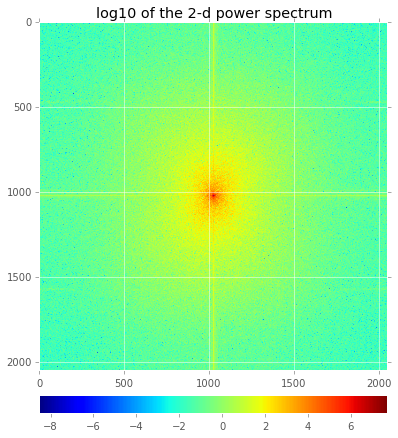

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(7,7))
ax.set_title('landsat a17')
im0=ax.imshow(np.log10(output.spectral_dens))
ax.set_title('log10 of the 2-d power spectrum')
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out=fig.colorbar(im0,orientation='horizontal',cax=cax)

# Created a new method called square_avg

### It seems to line up pretty well with the angualr method
        However, I can't quite figure out why normalizeing the avg_spec_sq by 25 rather than 25**2   produces the correct answer
        
#### Using some hand waving, that i'm not sure is entirely mathematically sound

    I was able to get a value that was very close to the varriance of tau

In [ ]:
avg_binwidth=5  #make the kradial bins 5 pixels wide
cell_size = 25.

output.square_avg(avg_binwidth)
tauVar = np.var(np.ndarray.flatten(tau))
square_sum = np.sum(output.avg_spec_sq)/(output.xdim*2*cell_size)*avg_binwidth

output.annular_avg(avg_binwidth)

output.graph_spectrum(kol_offset=2000.,title='Landsat {} power spectrum'.format(output.filename))

print ('Tau Var = ', tauVar)
print ('The integral of the power spectra is:', square_sum)


#  Low Pass Filter

In [ ]:
Filt_val = 1.

# samprate ... the number of samples / kilometer?
samprate = 1000./cell_size
filt = output.Filter(Filt_val,samprate)

# McBean #7


In [ ]:
#load data sampled at 20.8333 Hz

td=np.load('miami_tower.npz') #load temp, uvel, vvel, wvel, minutes
print('keys: ',td.keys())
print(td['description'])

sampleRate=20.833
nyquistfreq=sampleRate/2.


totsize=36000
wvel=td['wvel'][0:totsize].flatten()
uvel=td['uvel'][0:totsize].flatten()
vvel=td['vvel'][0:totsize].flatten()
temp=td['temp'][0:totsize].flatten()
wvel = wvel - np.mean(wvel)
uvel = uvel - np.mean(uvel)
vvel = vvel - np.mean(vvel)
temp= temp - np.mean(temp)
flux=wvel*temp


halfpoint=np.int(np.floor(totsize/2.))
frequencies=np.arange(0,halfpoint)
frequencies=frequencies/halfpoint
frequencies=frequencies*nyquistfreq

# raw spectrum -- no windowing or averaging
#First confirm Parseval's theorem
# (Numerical Recipes 12.1.10, p. 498)

thefft=np.fft.fft(wvel)
Power=np.real(thefft*np.conj(thefft))
print('check Wiener-Khichine theorem for wvel')
print('\nraw fft sum, full time series: %10.4f\n' % (np.sum(Power)/totsize**2.))
print('velocity variance: %10.4f\n' % (np.sum(wvel*wvel)/totsize))

k = 0.4


#
#   EQ 7
#
e_w = (Power_w*k**(5/3)/0.667)**(3/2)

fig,theAx=plt.subplots(1,1,figsize=(8,8))
frequencies[0]=np.NaN
e_w[0]=np.NaN
Power_half=e_w[:halfpoint:]
theAx.loglog(frequencies,Power_half)
theAx.set_title('raw e_w spectrum with $f^{-5/3}$')
theAx.set(xlabel='frequency (HZ)',ylabel='Power (m^2/s^2)')
#
# pick one point the line should pass through (by eye)
# note that y intercept will be at log10(freq)=0
# or freq=1 Hz
#
leftspec=np.log10(Power[1]*1.e-3)
logy=leftspec - 5./3.*np.log10(frequencies)
yvals=10.**logy
theAx.loglog(frequencies,yvals,'r-')
thePoint=theAx.plot(1.,Power[1]*1.e-3,'g+')
thePoint[0].set_markersize(15)
thePoint[0].set_marker('h')
thePoint[0].set_markerfacecolor('g')
